## Oxford-IIIT Pet Dataset 을 이용하여 segmentation, colorization을 위한 tfrecord 파일 만들기

이 실습에서는 Oxford-IIIT Pet Dataset을 이용하여 segmentation과 colorization을 위한 tfrecord 파일로 저장하는 부분까지 진행합니다.

8_0.과 8_1이 수행되어서 이미 dogs, dogs_val 등의 directory가 있고 training data와 validation data가 나누어져있어야 합니다.


In [1]:
## library import
import tensorflow as tf
import numpy as np
import os
import cv2
from PIL import Image
import shutil
import xml.etree.ElementTree as et
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [3]:
img_size = 224

In [4]:
cd '/content/gdrive/My Drive/TensorFlow_Training_13th'

In [5]:
## directory 정보
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'oxford_pet')
train_dir = os.path.join(data_dir, 'dogs')
val_dir = os.path.join(data_dir, 'dogs_val')
anno_dir = os.path.join(data_dir, 'annotations', 'trimaps')

In [6]:
## train, validation, annotation 파일 갯수 확인
n_train = len(os.listdir(train_dir))
n_val =len(os.listdir(val_dir))
n_anno = len(os.listdir(anno_dir))
print(n_train, n_val, n_anno)

2000 498 7390


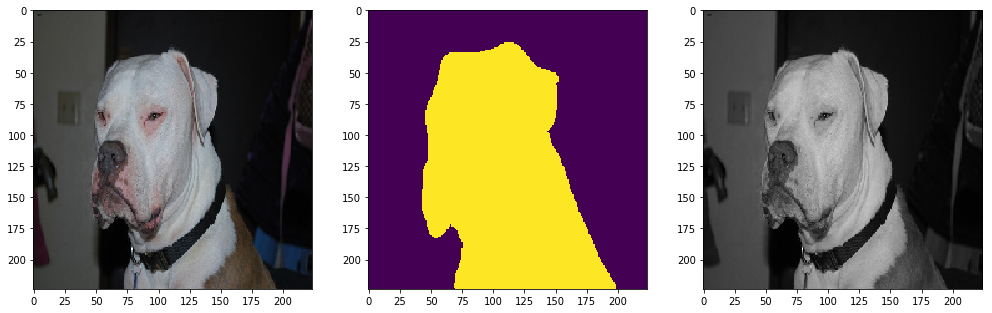

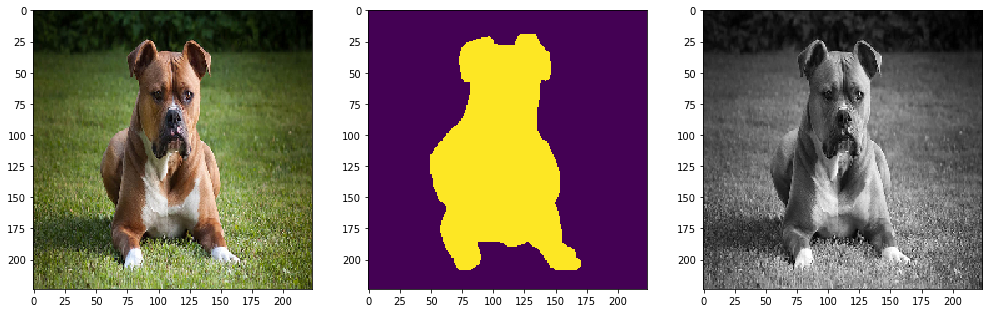

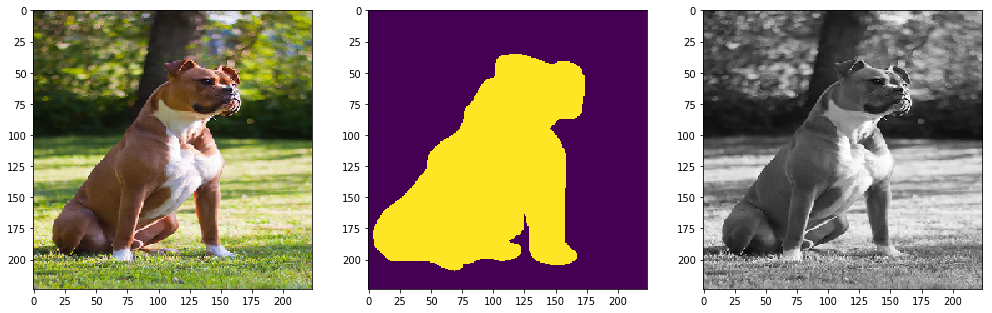

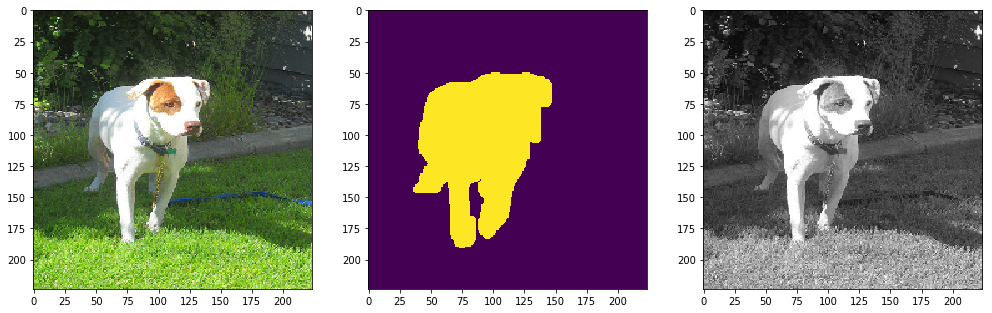

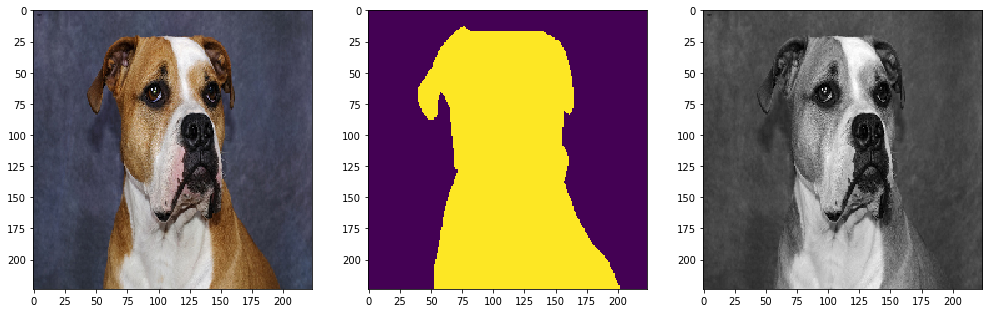

In [7]:
''' training dataset에서 num_figs만큼의 image를 가져와서
segmentation label,과 gray scale로 변환한 image를 확인'''

fnames = os.listdir(train_dir)

num_fig = 5
for i, fname in enumerate(fnames):
    ## training image
    fpath = os.path.join(train_dir, fname)    
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))
    img = np.array(img)
    
    ## segmentation label
    ## 원래 label은 1: foreground, 2: background, 3: not classified 로 구성됨
    ## 이것을 0: background, 1 : foreground & not classified로 변경
    sname = os.path.splitext(fname)[0] + '.png'
    spath = os.path.join(anno_dir, sname)    
    seg = Image.open(spath)
    seg = seg.resize((img_size, img_size))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0
    
    ## gray scale로 변환
    grayimg = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]
    
    plt.figure(figsize=(17, 6*num_fig))
    plt.subplot(num_fig,3,i*3+1)
    plt.imshow(img)
    plt.subplot(num_fig,3,i*3+2)    
    plt.imshow(seg)
    plt.subplot(num_fig,3,i*3+3)
    plt.imshow(grayimg, cmap='gray')    
    plt.show()
    
    if i == num_fig-1 : break

In [8]:
## tfrecord 파일 저장할 directory 생성
tfr_dir = os.path.join(cur_dir, 'dogs_tfr')
os.makedirs(tfr_dir, exist_ok=True)

In [9]:
## tfrecord 파일 경로 설정
tfr_train = 'dogs_seg_train.tfrecord'
tfr_val = 'dogs_seg_val.tfrecord'

tfr_train_dir = os.path.join(tfr_dir, tfr_train)
tfr_val_dir = os.path.join(tfr_dir, tfr_val)

In [10]:
## tfrecord writer
writer_train = tf.io.TFRecordWriter(tfr_train_dir)
writer_val = tf.io.TFRecordWriter(tfr_val_dir)

In [11]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [12]:
## train data의 tfrecord file 생성
fnames = os.listdir(train_dir)
n_train = 0
for fname in fnames:
    ## train data directory에서 file을 읽어서 serialize
    fpath = os.path.join(train_dir, fname)
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))    
    img = np.array(img)    
    
    sname = os.path.splitext(fname)[0] + '.png'
    spath = os.path.join(anno_dir, sname)
    seg = Image.open(spath)
    seg = seg.resize((img_size, img_size))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0    
    
    grayimg = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]    
    
    img_str = img.tobytes()
    seg_str = seg.tobytes()
    grayimg_str = grayimg.tobytes()
    
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(img_str),
            'seg': _bytes_feature(seg_str),
            'grayimg': _bytes_feature(grayimg_str)}))
    writer_train.write(example.SerializeToString())
    n_train += 1    

print(n_train)

2000


In [13]:
## validation data의 tfrecord file 생성
fnames = os.listdir(val_dir)
n_val = 0
for fname in fnames:
    ## validation data directory에서 file을 읽어서 serialize
    fpath = os.path.join(val_dir, fname)
    img = Image.open(fpath)
    img = img.resize((img_size, img_size))    
    img = np.array(img)
    img_str = img.tobytes()
    
    sname = os.path.splitext(fname)[0] + '.png'
    spath = os.path.join(anno_dir, sname)
    seg = Image.open(spath)
    seg = seg.resize((img_size, img_size))
    seg = np.array(seg)
    seg[seg>2] = 1
    seg[seg==2] = 0    
        
    grayimg = 0.2989*img[:,:,0] + 0.5870*img[:,:,1] + 0.1140*img[:,:,2]    
    
    img_str = img.tobytes()
    seg_str = seg.tobytes()
    grayimg_str = grayimg.tobytes()
    
    example = tf.train.Example(features=tf.train.Features(feature={
            'image': _bytes_feature(img_str),
            'seg': _bytes_feature(seg_str),
            'grayimg': _bytes_feature(grayimg_str)}))
    writer_val.write(example.SerializeToString())
    n_val += 1    

print(n_val)

498
